
# MNIST "4" — Latent Centers → Reconstructions

This notebook:
1. Loads latent vectors (`latents.h5`) and labels from your results directory.
2. Selects only the vectors for the label **4**.
3. Computes **arithmetic mean**, **coordinate-wise median**, and **geometric median** in latent space.
4. Rebuilds the **decoder** architecture, loads your saved `decoder_weights.h5`, decodes each representative latent, and plots the reconstructions.

> **Update first:** Set `BASE_RESULTS_DIR` to your directory that contains:
> - `latents.h5` (datasets: `z` and `labels`)
> - `decoder_weights.h5` (weights saved from the training script)


In [1]:

# ───────────────────────────────────────────────
# Configuration — update this to your directory
# ───────────────────────────────────────────────
BASE_RESULTS_DIR = r"D:\Results\082725_mnist_ae_2"  # <-- change if needed

LATENTS_H5   = rf"{BASE_RESULTS_DIR}\latents.h5"
DECODER_H5   = rf"{BASE_RESULTS_DIR}\decoder_weights.h5"
SAVE_FIG_PNG = rf"{BASE_RESULTS_DIR}\recon_label4_centers.png"

print("Using:")
print("  LATENTS_H5:", LATENTS_H5)
print("  DECODER_H5:", DECODER_H5)
print("  SAVE_FIG_PNG:", SAVE_FIG_PNG)


Using:
  LATENTS_H5: D:\Results\082725_mnist_ae_2\latents.h5
  DECODER_H5: D:\Results\082725_mnist_ae_2\decoder_weights.h5
  SAVE_FIG_PNG: D:\Results\082725_mnist_ae_2\recon_label4_centers.png


In [2]:

import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Attempt TensorFlow import; raise a helpful error if missing.
try:
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose, ReLU
except Exception as e:
    raise ImportError(
        "TensorFlow is required in this notebook to rebuild the decoder and do reconstructions.\n"
        "Please install it in your environment, for example:\n"
        "  pip install tensorflow\n\n"
        f"Original import error: {e}"
    )


In [3]:

def geometric_median(X, eps=1e-5, max_iter=512, verbose=False):
    """
    Weiszfeld's algorithm for the geometric median in R^d.
    X: (n_samples, d) array
    Returns: (d,) geometric median.
    """
    X = np.asarray(X, dtype=np.float64)
    # Good initializer: coordinate-wise median
    m = np.median(X, axis=0).astype(np.float64, copy=True)

    for it in range(max_iter):
        diffs = X - m  # (n,d)
        dists = np.linalg.norm(diffs, axis=1)  # (n,)

        # If m coincides with a data point, return that point
        zero_mask = dists < eps
        if np.any(zero_mask):
            return X[zero_mask][0].astype(np.float32)

        inv_d = 1.0 / np.maximum(dists, eps)
        weights = inv_d / inv_d.sum()
        m_new = (weights[:, None] * X).sum(axis=0)

        move = np.linalg.norm(m_new - m)
        m = m_new
        if verbose and (it % 20 == 0):
            print(f"[iter {it}] move={move:.3e}")
        if move < eps:
            break

    return m.astype(np.float32)


In [4]:

with h5py.File(LATENTS_H5, "r") as hf:
    z_all = hf["z"][:]        # (N, latent_dim)
    y_all = hf["labels"][:]   # (N,)
z_all = z_all.astype(np.float32, copy=False)

print("z_all shape:", z_all.shape)
print("labels shape:", y_all.shape)
latent_dim = z_all.shape[1]

# Select label == 4
mask4 = (y_all == 4)
z4 = z_all[mask4]
print(f"Found {z4.shape[0]} latents for label '4'.")


z_all shape: (70000, 256)
labels shape: (70000,)
Found 6824 latents for label '4'.


In [5]:

# Arithmetic mean and coordinate-wise median
z4_mean   = z4.mean(axis=0).astype(np.float32)
z4_median = np.median(z4, axis=0).astype(np.float32)

# Geometric median (robust L1 in vector space)
z4_geomed = geometric_median(z4, eps=1e-5, max_iter=512, verbose=False)

print("Computed centers:")
print("  mean   shape:", z4_mean.shape)
print("  median shape:", z4_median.shape)
print("  geomed shape:", z4_geomed.shape)


Computed centers:
  mean   shape: (256,)
  median shape: (256,)
  geomed shape: (256,)


In [6]:

# Rebuild the decoder EXACTLY as in training:
latent_in = Input((latent_dim,), name="z_sampling")
x = Dense(7 * 7 * 128)(latent_in)
x = Reshape((7, 7, 128))(x)

# Two upsampling blocks matching your script
for filters in [128, 64]:
    x = Conv2DTranspose(filters, 3, strides=2, padding="same")(x)
    x = ReLU()(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = ReLU()(x)

decoded = tf.keras.layers.Conv2D(1, 3, padding="same", activation="sigmoid", name="decoder_output")(x)
decoder = Model(latent_in, decoded, name="decoder")

# Load weights
if not os.path.exists(DECODER_H5):
    raise FileNotFoundError(f"decoder_weights.h5 not found at: {DECODER_H5}")
decoder.load_weights(DECODER_H5)
print("Loaded decoder weights.")


Loaded decoder weights.


In [7]:

centers = {
    "Arithmetic mean": z4_mean,
    "Coordinate median": z4_median,
    "Geometric median": z4_geomed,
}

decoded_imgs = {}
for name, zc in centers.items():
    pred = decoder.predict(zc[None, :], verbose=0)  # (1, 28, 28, 1)
    decoded_imgs[name] = pred[0, :, :, 0]  # (28,28)

list(decoded_imgs.keys())


['Arithmetic mean', 'Coordinate median', 'Geometric median']

Saved figure to: D:\Results\082725_mnist_ae_2\recon_label4_centers.png


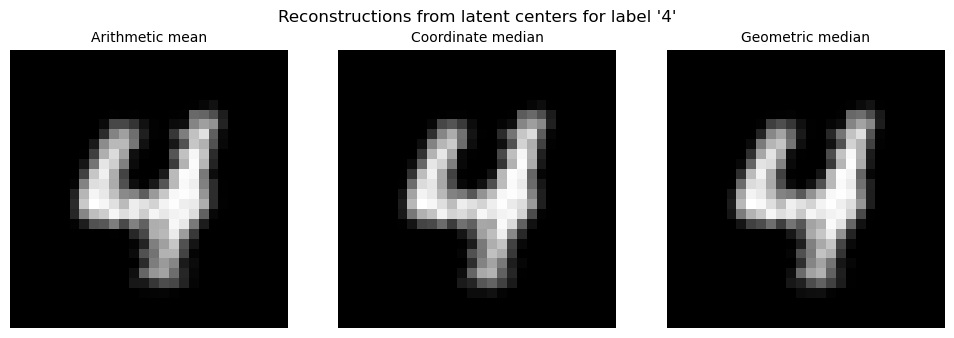

In [8]:


fig, axes = plt.subplots(1, 3, figsize=(10, 3.4))
for ax, (name, img) in zip(axes, decoded_imgs.items()):
    ax.imshow(img, cmap="gray")
    ax.set_title(name, fontsize=10)
    ax.axis("off")
fig.suptitle("Reconstructions from latent centers for label '4'", fontsize=12)
fig.tight_layout()
plt.show()
